## Adversarial Autoencoder

In [1]:
import os

import numpy as np
np.random.seed(0)
np.set_printoptions(suppress=True)

from sklearn.datasets import fetch_mldata
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import decomposition

import pandas as pd

import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch import optim
from utils import progress, count_parameters, visualize, get_batch

cuda = torch.cuda.is_available() # True if cuda is available, False otherwise
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
print('Training on %s' % ('GPU' if cuda else 'CPU'))


%matplotlib inline

Training on CPU


In [12]:
mnist = fetch_mldata('MNIST original', data_home='.', )
mnist.data = mnist.data.astype(np.float32)
mnist.data = mnist.data / 255.

In [13]:
X_train = mnist.data[:60000]
X_test = mnist.data[60000:]

In [219]:
hidden = 200
zdim = 2
encoder = nn.Sequential(
                        nn.Linear(28*28, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, zdim)
                        )
decoder = nn.Sequential(
                        nn.ReLU(),
                        nn.Linear(zdim, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, 28*28),
                        nn.Sigmoid()
                        )
discriminator = nn.Sequential(
                        nn.Linear(zdim, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, hidden),
                        nn.ReLU(),
                        nn.Linear(hidden, 2))

autoencoder = nn.Sequential(encoder, decoder)
count_parameters(autoencoder)

# opt_ae = torch.optim.SGD(autoencoder.parameters(), lr=0.01, momentum=0.9)
# opt_g = torch.optim.SGD(encoder.parameters(), lr=0.1)
# opt_d = torch.optim.SGD(discriminator.parameters(), lr=0.1)
opt_ae = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
opt_g = torch.optim.Adam(encoder.parameters(), lr=0.001)
opt_d = torch.optim.Adam(discriminator.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

395,986 parameters
395,986 trainable parameters


In [214]:
def clear_grad(models):
    for m in models:
        m.zero_grad()

In [220]:
info = {}
info['recon_loss'] = []
info['discriminator_loss'] = []
info['generator_loss'] = []

recon_loss = []
discriminator_loss = []
generator_loss = []

models = [encoder, decoder, discriminator]
batch_size = 32
# N = X_train.shape[0]
N = 5000

autoencoder.train()
max_epochs = 200
for i in range(1, max_epochs + 1):
    start = time.time()
    for j, x_numpy in enumerate(get_batch(X_train[:N], batch_size, allow_smaller_batch=True)):
        batch = x_numpy.shape[0]
        ones = Variable(torch.ones(batch)).type(LongTensor)
        zeros = Variable(torch.zeros(batch)).type(LongTensor)
        
        # (1) Reconstruction loss
        clear_grad(models)
#         autoencoder.zero_grad()
        x = Variable(torch.from_numpy(x_numpy).type(FloatTensor).view(-1, 28*28))
        x_ = autoencoder(x)
        autoencoder_loss = torch.sum(torch.pow(x - x_, 2)) / batch_size
#         autoencoder_loss = torch.dist(x, x_)
#         autoencoder_loss = torch.nn.L1Loss()(x, x_)
        autoencoder_loss.backward()
        opt_ae.step()

        
        # (2) Train the discriminator
        clear_grad(models)
        z_fake = Variable(encoder(x).data)
        z_real = Variable(5. * torch.randn(z_fake.size())).type(FloatTensor)
        z_fake_d = discriminator(z_fake)
        z_real_d = discriminator(z_real)

        loss_real_d = criterion(z_real_d.squeeze(), ones)
        loss_fake_d = criterion(z_fake_d.squeeze(), zeros)
        loss_d = (loss_real_d + loss_fake_d)
        loss_d.backward()
        opt_d.step()
            
        # (3) Generator step
        clear_grad(models)
        x = Variable(torch.from_numpy(x_numpy).type(FloatTensor).view(-1, 28*28))
        z_fake = encoder(x)
        z_fake_d = discriminator(z_fake)
        loss_g = criterion(z_fake_d.squeeze(), ones)
        loss_g.backward()
        opt_g.step()
    
        recon_loss.append(autoencoder_loss.data)
        discriminator_loss.append(loss_d.data)
        generator_loss.append(loss_g.data)
        
        progress(recon_loss, i, max_epochs, j + 1, batch_size, N, start)
    else:
        
        # Update learning rate schedules
        if i == 50:
            print('Decreasing lr of autoencoder to 0.001.')
            opt_ae.param_groups[0]['lr'] = 0.001
        
        
        # Do some logging

        print('--> ae: %.3f d: %.3f g: %.3f' %
          (np.mean(recon_loss), np.mean(discriminator_loss), np.mean(generator_loss)))

        info['recon_loss'].append(np.mean(recon_loss))
        info['discriminator_loss'].append(np.mean(discriminator_loss))
        info['generator_loss'].append(np.mean(generator_loss))

        recon_loss = []
        discriminator_loss = []
        generator_loss = []

[  1/200][==================================================] 100% – loss 54.53448 -    3s [1512 fps]
--> ae: 54.534 d: 0.675 g: 1.976
[  2/200][==================================================] 100% – loss 41.06945 -    2s [1793 fps]
--> ae: 41.069 d: 0.977 g: 1.576
[  3/200][==================================================] 100% – loss 37.28077 -    2s [1798 fps]
--> ae: 37.281 d: 1.227 g: 0.953
[  4/200][==================================================] 100% – loss 34.35588 -    2s [1758 fps]
--> ae: 34.356 d: 1.335 g: 0.855
[  5/200][==================================================] 100% – loss 38.85494 -    5s [861 fps]
--> ae: 38.855 d: 1.308 g: 1.031
[  6/200][==================================================] 100% – loss 36.80670 -    7s [674 fps]
--> ae: 36.807 d: 1.340 g: 0.820
[  7/200][==================================================] 100% – loss 37.27238 -    9s [548 fps]
--> ae: 37.272 d: 1.355 g: 0.804
[  8/200][================================================

KeyboardInterrupt: 

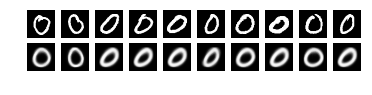

In [221]:
autoencoder.eval()
visualize(autoencoder, X_train[:5000], in_size=[28*28], dtype=FloatTensor)

In [222]:
codes = encoder(Variable(torch.from_numpy(X_train[:5000]))).data.numpy()

In [225]:
plt.rcParams['figure.figsize'] = (8, 8)

In [228]:
np.std(codes)

4.9230328

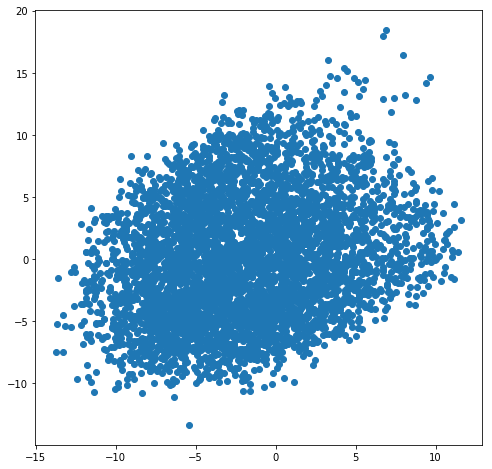

In [226]:
plt.scatter(codes[:, 0], codes[:, 1])

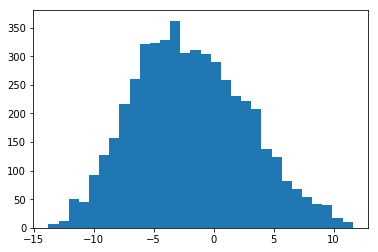

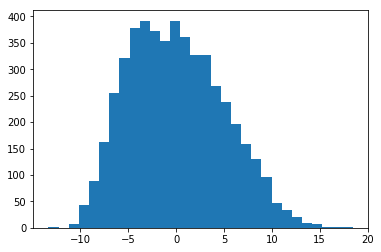

In [224]:
for i in range(2):
    plt.hist(codes[:, i], bins=30);
    plt.show()

In [209]:
info.keys()

dict_keys(['recon_loss', 'discriminator_loss', 'generator_loss'])

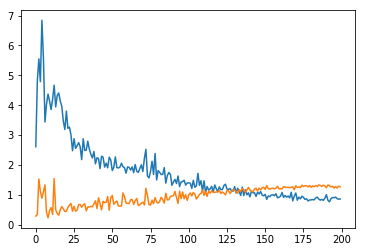

In [212]:
plt.plot(info['generator_loss'])
plt.plot(info['discriminator_loss'])